<a href="https://colab.research.google.com/github/farrelrassya/teachingMLDL/blob/main/02.%20Deep%20Learning/01.%20Week%201/Notebooks/03.backpropagation_enhanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Backpropagation: The Heart of Deep Learning

## How Neural Networks Learn

In previous notebooks, we used `loss.backward()` to train networks. But what actually happens behind the scenes?

This notebook covers:

1. **Intuition**: What is backpropagation and why do we need it?
2. **Chain Rule**: The mathematical foundation of backprop
3. **Computational Graphs**: Visualizing the flow of computation
4. **Manual Backprop**: Implementing from scratch
5. **Vector/Matrix Calculus**: Gradients for layers
6. **PyTorch Autograd**: How PyTorch does it automatically
7. **Exercises**: Practice with manual + Python verification

---

## Setup

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import warnings
warnings.filterwarnings('ignore')

# Set random seed
torch.manual_seed(42)
np.random.seed(42)

# Dark theme
plt.style.use('default')
plt.rcParams['figure.facecolor'] = '#0d1117'
plt.rcParams['axes.facecolor'] = '#161b22'
plt.rcParams['axes.edgecolor'] = '#c9d1d9'
plt.rcParams['axes.labelcolor'] = '#c9d1d9'
plt.rcParams['text.color'] = '#c9d1d9'
plt.rcParams['xtick.color'] = '#c9d1d9'
plt.rcParams['ytick.color'] = '#c9d1d9'
plt.rcParams['grid.color'] = '#30363d'
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 11

print("Ready!")

Ready!


---
# Part 1: Intuition - Why Backpropagation?

## 1.1 The Learning Problem

Neural networks have thousands (or millions) of **parameters** (weights and biases).

**Goal**: Find parameter values that minimize the **loss function**.

**Question**: How do we change each parameter to make the loss decrease?

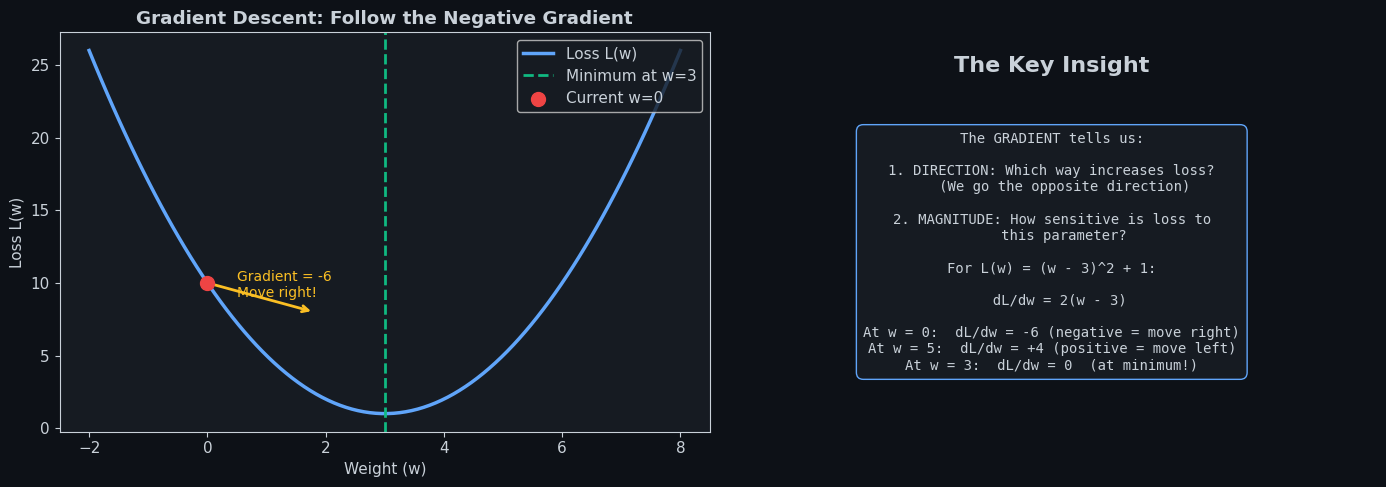

In [2]:
# Illustration: Simple loss landscape
def simple_loss(w):
    return (w - 3) ** 2 + 1

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor('#0d1117')

# Panel 1: Loss landscape
w_vals = np.linspace(-2, 8, 100)
loss_vals = simple_loss(w_vals)

ax1 = axes[0]
ax1.plot(w_vals, loss_vals, color='#60A5FA', linewidth=2.5, label='Loss L(w)')
ax1.axvline(x=3, color='#10B981', linestyle='--', linewidth=2, label='Minimum at w=3')

# Current position
w_current = 0
ax1.scatter([w_current], [simple_loss(w_current)], color='#EF4444', s=100, zorder=5, label=f'Current w={w_current}')

# Gradient arrow
gradient = 2 * (w_current - 3)  # dL/dw = 2(w-3)
ax1.annotate('', xy=(w_current - 0.3*gradient, simple_loss(w_current) - 2),
            xytext=(w_current, simple_loss(w_current)),
            arrowprops=dict(arrowstyle='->', color='#FBBF24', lw=2))
ax1.text(w_current + 0.5, simple_loss(w_current) - 1, f'Gradient = {gradient}\nMove right!',
        color='#FBBF24', fontsize=10)

ax1.set_xlabel('Weight (w)')
ax1.set_ylabel('Loss L(w)')
ax1.set_title('Gradient Descent: Follow the Negative Gradient', fontweight='bold')
ax1.legend(loc='upper right')

# Panel 2: The answer
ax2 = axes[1]
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 10)
ax2.axis('off')

ax2.text(5, 9, 'The Key Insight', ha='center', fontsize=16, fontweight='bold')

text = '''The GRADIENT tells us:

1. DIRECTION: Which way increases loss?
   (We go the opposite direction)

2. MAGNITUDE: How sensitive is loss to
   this parameter?

For L(w) = (w - 3)^2 + 1:

  dL/dw = 2(w - 3)

At w = 0:  dL/dw = -6 (negative = move right)
At w = 5:  dL/dw = +4 (positive = move left)
At w = 3:  dL/dw = 0  (at minimum!)'''

ax2.text(5, 4.5, text, ha='center', va='center', fontsize=10, family='monospace',
        bbox=dict(boxstyle='round', facecolor='#161b22', edgecolor='#60A5FA', pad=0.5))

plt.tight_layout()
plt.show()

## 1.2 The Challenge: Deep Networks

For **one parameter**, computing the gradient is easy.

But neural networks have:
- Multiple layers
- Each layer has many parameters
- Parameters affect the loss through a **chain of operations**

**Backpropagation** efficiently computes gradients for ALL parameters in ONE backward pass!

---
# Part 2: Chain Rule - The Mathematical Foundation

## 2.1 Review: Chain Rule

If $y = f(g(x))$, then:

$$\frac{dy}{dx} = \frac{dy}{dg} \cdot \frac{dg}{dx}$$

**Example**: $y = (2x + 1)^2$

Let $g = 2x + 1$, so $y = g^2$

$$\frac{dy}{dx} = \frac{dy}{dg} \cdot \frac{dg}{dx} = 2g \cdot 2 = 4(2x + 1)$$

In [3]:
# Example: y = (2x + 1)^2
# Let g = 2x + 1, then y = g^2

x = 3.0

# Forward pass
g = 2 * x + 1      # g = 7
y = g ** 2         # y = 49

# Backward pass (chain rule)
dy_dg = 2 * g      # dy/dg = 2g = 14
dg_dx = 2          # dg/dx = 2
dy_dx = dy_dg * dg_dx  # dy/dx = 14 * 2 = 28

print("CHAIN RULE EXAMPLE: y = (2x + 1)^2")
print("="*50)
print(f"\nAt x = {x}:")
print(f"  g = 2x + 1 = {g}")
print(f"  y = g^2 = {y}")
print(f"\nGradients:")
print(f"  dy/dg = 2g = {dy_dg}")
print(f"  dg/dx = {dg_dx}")
print(f"  dy/dx = dy/dg * dg/dx = {dy_dg} * {dg_dx} = {dy_dx}")

# Verify with PyTorch
x_t = torch.tensor(3.0, requires_grad=True)
y_t = (2 * x_t + 1) ** 2
y_t.backward()
print(f"\nPyTorch verification: dy/dx = {x_t.grad.item()}")

CHAIN RULE EXAMPLE: y = (2x + 1)^2

At x = 3.0:
  g = 2x + 1 = 7.0
  y = g^2 = 49.0

Gradients:
  dy/dg = 2g = 14.0
  dg/dx = 2
  dy/dx = dy/dg * dg/dx = 14.0 * 2 = 28.0

PyTorch verification: dy/dx = 28.0


## 2.2 Chain Rule with Multiple Variables

What if there are **multiple paths**?

$$\frac{\partial L}{\partial x} = \sum_{\text{all paths}} \frac{\partial L}{\partial \text{path}} \cdot \frac{\partial \text{path}}{\partial x}$$

**Example**: $z = xy$, then $L = z + x$

$x$ affects $L$ through TWO paths:
1. Directly: $x \to L$
2. Through $z$: $x \to z \to L$

In [4]:
# Example: z = x*y, then L = z + x
# x affects L through TWO paths

x, y = 3.0, 2.0

# Forward pass
z = x * y          # z = 6
L = z + x          # L = 9

# Backward pass
dL_dz = 1          # L = z + x, so dL/dz = 1
dL_dx_direct = 1   # L = z + x, so dL/dx = 1 (direct path)

dz_dx = y          # z = xy, so dz/dx = y
dL_dx_via_z = dL_dz * dz_dx  # through z path

dL_dx_total = dL_dx_direct + dL_dx_via_z  # sum all paths!

print("MULTIPLE PATHS EXAMPLE")
print("="*50)
print("L = z + x, where z = x*y")
print(f"\nAt x = {x}, y = {y}:")
print(f"  z = x*y = {z}")
print(f"  L = z + x = {L}")
print(f"\nGradient of L w.r.t. x:")
print(f"  Path 1 (direct):  dL/dx = {dL_dx_direct}")
print(f"  Path 2 (via z):   dL/dz * dz/dx = {dL_dz} * {dz_dx} = {dL_dx_via_z}")
print(f"  Total:            {dL_dx_direct} + {dL_dx_via_z} = {dL_dx_total}")

# Verify
x_t = torch.tensor(3.0, requires_grad=True)
y_t = torch.tensor(2.0, requires_grad=True)
z_t = x_t * y_t
L_t = z_t + x_t
L_t.backward()
print(f"\nPyTorch verification: dL/dx = {x_t.grad.item()}")

MULTIPLE PATHS EXAMPLE
L = z + x, where z = x*y

At x = 3.0, y = 2.0:
  z = x*y = 6.0
  L = z + x = 9.0

Gradient of L w.r.t. x:
  Path 1 (direct):  dL/dx = 1
  Path 2 (via z):   dL/dz * dz/dx = 1 * 2.0 = 2.0
  Total:            1 + 2.0 = 3.0

PyTorch verification: dL/dx = 3.0


---
# Part 3: Computational Graphs

## 3.1 What is a Computational Graph?

A **computational graph** is a directed acyclic graph (DAG) that represents:
- **Nodes**: Variables (inputs, intermediate values, output)
- **Edges**: Operations that transform variables

This makes it easy to:
1. Visualize the forward pass
2. Systematically compute gradients in the backward pass

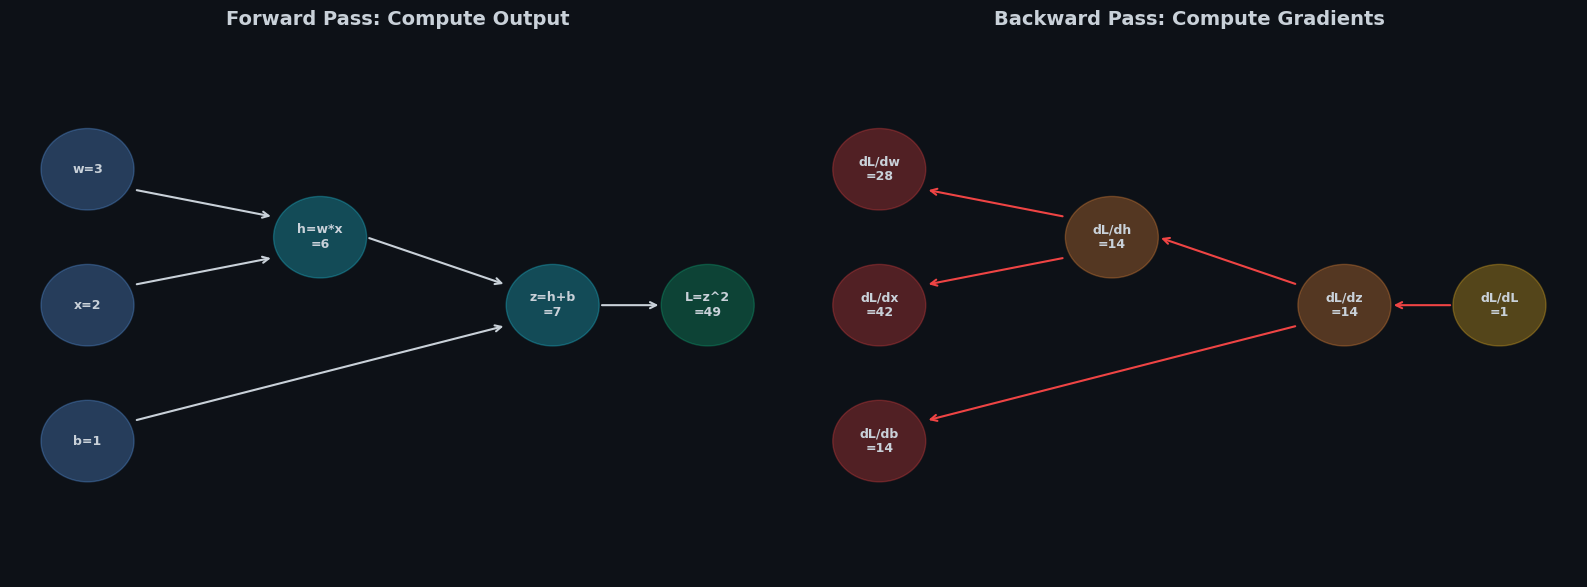

In [5]:
def draw_computational_graph():
    """Visualize computational graph for y = (w*x + b)^2"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.patch.set_facecolor('#0d1117')

    # Panel 1: Forward Pass
    ax1 = axes[0]
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 8)
    ax1.axis('off')
    ax1.set_title('Forward Pass: Compute Output', fontweight='bold', fontsize=14)

    # Nodes
    nodes = [
        (1, 6, 'w=3', '#60A5FA'),
        (1, 4, 'x=2', '#60A5FA'),
        (1, 2, 'b=1', '#60A5FA'),
        (4, 5, 'h=w*x\n=6', '#22D3EE'),
        (7, 4, 'z=h+b\n=7', '#22D3EE'),
        (9, 4, 'L=z^2\n=49', '#10B981'),
    ]

    for x, y, text, color in nodes:
        circle = plt.Circle((x, y), 0.6, color=color, alpha=0.3)
        ax1.add_patch(circle)
        ax1.text(x, y, text, ha='center', va='center', fontsize=9, fontweight='bold')

    # Arrows
    arrows = [
        (1.6, 5.7, 3.4, 5.3),  # w -> h
        (1.6, 4.3, 3.4, 4.7),  # x -> h
        (1.6, 2.3, 6.4, 3.7),  # b -> z
        (4.6, 5, 6.4, 4.3),    # h -> z
        (7.6, 4, 8.4, 4),      # z -> L
    ]

    for x1, y1, x2, y2 in arrows:
        ax1.annotate('', xy=(x2, y2), xytext=(x1, y1),
                    arrowprops=dict(arrowstyle='->', color='#c9d1d9', lw=1.5))

    # Panel 2: Backward Pass
    ax2 = axes[1]
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 8)
    ax2.axis('off')
    ax2.set_title('Backward Pass: Compute Gradients', fontweight='bold', fontsize=14)

    # Nodes with gradients
    nodes_back = [
        (1, 6, 'dL/dw\n=28', '#EF4444'),
        (1, 4, 'dL/dx\n=42', '#EF4444'),
        (1, 2, 'dL/db\n=14', '#EF4444'),
        (4, 5, 'dL/dh\n=14', '#FB923C'),
        (7, 4, 'dL/dz\n=14', '#FB923C'),
        (9, 4, 'dL/dL\n=1', '#FBBF24'),
    ]

    for x, y, text, color in nodes_back:
        circle = plt.Circle((x, y), 0.6, color=color, alpha=0.3)
        ax2.add_patch(circle)
        ax2.text(x, y, text, ha='center', va='center', fontsize=9, fontweight='bold')

    # Backward arrows
    for x1, y1, x2, y2 in arrows:
        ax2.annotate('', xy=(x1, y1), xytext=(x2, y2),
                    arrowprops=dict(arrowstyle='->', color='#EF4444', lw=1.5))

    plt.tight_layout()
    plt.show()

draw_computational_graph()

## 3.2 Manual Calculation

Let's compute gradients manually for $L = (w \cdot x + b)^2$

With values: $w=3$, $x=2$, $b=1$

In [6]:
# Values
w, x, b = 3.0, 2.0, 1.0

print("="*60)
print("FORWARD PASS")
print("="*60)

# Forward pass (save intermediate values)
h = w * x          # h = 6
z = h + b          # z = 7
L = z ** 2         # L = 49

print(f"Step 1: h = w * x = {w} * {x} = {h}")
print(f"Step 2: z = h + b = {h} + {b} = {z}")
print(f"Step 3: L = z^2 = {z}^2 = {L}")

print("\n" + "="*60)
print("BACKWARD PASS")
print("="*60)

# Backward pass
dL_dL = 1                    # Start with 1
print(f"\nStart: dL/dL = {dL_dL}")

dL_dz = dL_dL * (2 * z)      # L = z^2, so dL/dz = 2z
print(f"\nStep 1: dL/dz = dL/dL * d(z^2)/dz = {dL_dL} * 2*{z} = {dL_dz}")

dL_dh = dL_dz * 1            # z = h + b, so dz/dh = 1
dL_db = dL_dz * 1            # z = h + b, so dz/db = 1
print(f"Step 2: dL/dh = dL/dz * dz/dh = {dL_dz} * 1 = {dL_dh}")
print(f"        dL/db = dL/dz * dz/db = {dL_dz} * 1 = {dL_db}")

dL_dw = dL_dh * x            # h = w*x, so dh/dw = x
dL_dx = dL_dh * w            # h = w*x, so dh/dx = w
print(f"Step 3: dL/dw = dL/dh * dh/dw = {dL_dh} * {x} = {dL_dw}")
print(f"        dL/dx = dL/dh * dh/dx = {dL_dh} * {w} = {dL_dx}")

print("\n" + "="*60)
print("RESULTS")
print("="*60)
print(f"dL/dw = {dL_dw}")
print(f"dL/dx = {dL_dx}")
print(f"dL/db = {dL_db}")

FORWARD PASS
Step 1: h = w * x = 3.0 * 2.0 = 6.0
Step 2: z = h + b = 6.0 + 1.0 = 7.0
Step 3: L = z^2 = 7.0^2 = 49.0

BACKWARD PASS

Start: dL/dL = 1

Step 1: dL/dz = dL/dL * d(z^2)/dz = 1 * 2*7.0 = 14.0
Step 2: dL/dh = dL/dz * dz/dh = 14.0 * 1 = 14.0
        dL/db = dL/dz * dz/db = 14.0 * 1 = 14.0
Step 3: dL/dw = dL/dh * dh/dw = 14.0 * 2.0 = 28.0
        dL/dx = dL/dh * dh/dx = 14.0 * 3.0 = 42.0

RESULTS
dL/dw = 28.0
dL/dx = 42.0
dL/db = 14.0


In [7]:
# Verify with PyTorch
w_t = torch.tensor(3.0, requires_grad=True)
x_t = torch.tensor(2.0, requires_grad=True)
b_t = torch.tensor(1.0, requires_grad=True)

L_t = (w_t * x_t + b_t) ** 2
L_t.backward()

print("PyTorch Verification:")
print(f"dL/dw = {w_t.grad.item()} {'[MATCH]' if w_t.grad.item() == dL_dw else '[MISMATCH]'}")
print(f"dL/dx = {x_t.grad.item()} {'[MATCH]' if x_t.grad.item() == dL_dx else '[MISMATCH]'}")
print(f"dL/db = {b_t.grad.item()} {'[MATCH]' if b_t.grad.item() == dL_db else '[MISMATCH]'}")

PyTorch Verification:
dL/dw = 28.0 [MATCH]
dL/dx = 42.0 [MATCH]
dL/db = 14.0 [MATCH]


---
# Part 4: Backprop in Neural Networks

## 4.1 Single Neuron

A neuron with sigmoid activation:

$$a = \sigma(w \cdot x + b)$$

where $\sigma(z) = \frac{1}{1 + e^{-z}}$

**Important**: The derivative of sigmoid is $\sigma'(z) = \sigma(z)(1 - \sigma(z))$

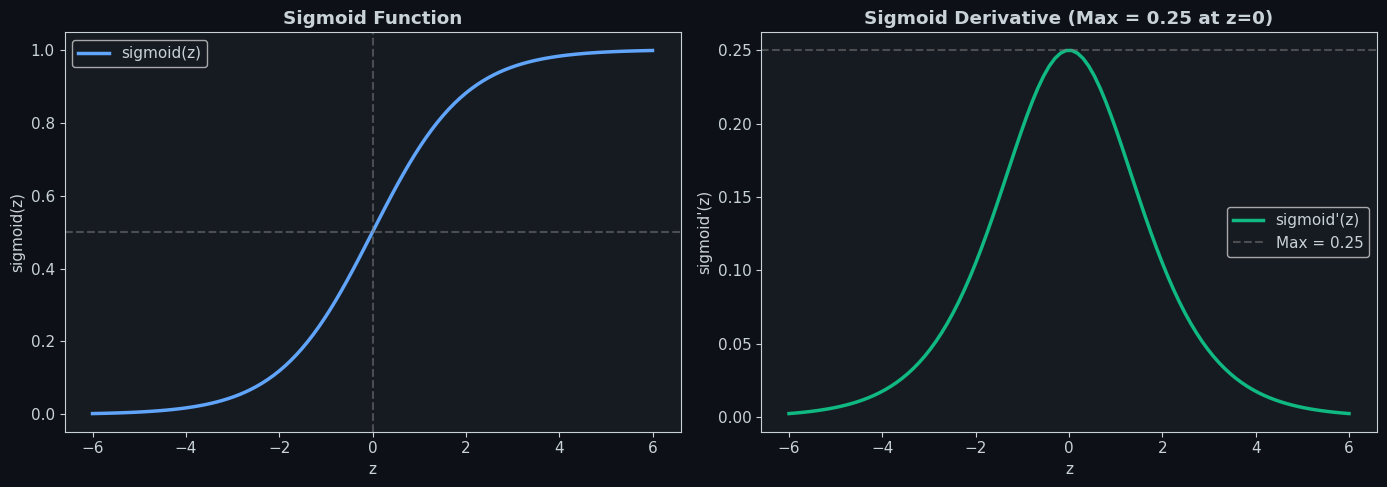


KEY INSIGHT: Sigmoid derivative is always <= 0.25
This causes VANISHING GRADIENTS in deep networks!


In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

# Visualize sigmoid and its derivative
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor('#0d1117')

z = np.linspace(-6, 6, 100)

ax1 = axes[0]
ax1.plot(z, sigmoid(z), color='#60A5FA', linewidth=2.5, label='sigmoid(z)')
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('z')
ax1.set_ylabel('sigmoid(z)')
ax1.set_title('Sigmoid Function', fontweight='bold')
ax1.legend()

ax2 = axes[1]
ax2.plot(z, sigmoid_derivative(z), color='#10B981', linewidth=2.5, label="sigmoid'(z)")
ax2.axhline(y=0.25, color='gray', linestyle='--', alpha=0.5, label='Max = 0.25')
ax2.set_xlabel('z')
ax2.set_ylabel("sigmoid'(z)")
ax2.set_title('Sigmoid Derivative (Max = 0.25 at z=0)', fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

print("\nKEY INSIGHT: Sigmoid derivative is always <= 0.25")
print("This causes VANISHING GRADIENTS in deep networks!")

In [9]:
# Single neuron backprop
print("="*60)
print("SINGLE NEURON: a = sigmoid(w*x + b)")
print("="*60)

# Values
w, x, b = 0.5, 2.0, 0.1

# Forward pass
z = w * x + b           # z = 1.1
a = sigmoid(z)          # a = 0.7503

print(f"\nForward pass:")
print(f"  z = w*x + b = {w}*{x} + {b} = {z}")
print(f"  a = sigmoid(z) = sigmoid({z}) = {a:.4f}")

# Suppose loss is L = (a - y)^2 with target y = 1
y = 1.0
L = (a - y) ** 2
print(f"  L = (a - y)^2 = ({a:.4f} - {y})^2 = {L:.4f}")

# Backward pass
dL_da = 2 * (a - y)                    # dL/da
da_dz = sigmoid_derivative(z)          # da/dz = sigma(z)(1-sigma(z))
dL_dz = dL_da * da_dz                  # Chain rule

dL_dw = dL_dz * x                      # dz/dw = x
dL_dx = dL_dz * w                      # dz/dx = w
dL_db = dL_dz * 1                      # dz/db = 1

print(f"\nBackward pass:")
print(f"  dL/da = 2(a - y) = {dL_da:.4f}")
print(f"  da/dz = sigmoid'(z) = {da_dz:.4f}")
print(f"  dL/dz = dL/da * da/dz = {dL_dz:.4f}")
print(f"\nGradients:")
print(f"  dL/dw = dL/dz * x = {dL_dz:.4f} * {x} = {dL_dw:.4f}")
print(f"  dL/db = dL/dz * 1 = {dL_db:.4f}")

# Verify with PyTorch
w_t = torch.tensor(w, requires_grad=True)
x_t = torch.tensor(x)
b_t = torch.tensor(b, requires_grad=True)
y_t = torch.tensor(y)

a_t = torch.sigmoid(w_t * x_t + b_t)
L_t = (a_t - y_t) ** 2
L_t.backward()

print(f"\nPyTorch verification:")
print(f"  dL/dw = {w_t.grad.item():.4f} (manual: {dL_dw:.4f})")
print(f"  dL/db = {b_t.grad.item():.4f} (manual: {dL_db:.4f})")

SINGLE NEURON: a = sigmoid(w*x + b)

Forward pass:
  z = w*x + b = 0.5*2.0 + 0.1 = 1.1
  a = sigmoid(z) = sigmoid(1.1) = 0.7503
  L = (a - y)^2 = (0.7503 - 1.0)^2 = 0.0624

Backward pass:
  dL/da = 2(a - y) = -0.4995
  da/dz = sigmoid'(z) = 0.1874
  dL/dz = dL/da * da/dz = -0.0936

Gradients:
  dL/dw = dL/dz * x = -0.0936 * 2.0 = -0.1872
  dL/db = dL/dz * 1 = -0.0936

PyTorch verification:
  dL/dw = -0.1872 (manual: -0.1872)
  dL/db = -0.0936 (manual: -0.0936)


## 4.2 Two-Layer Network (Full Example)

Now let's implement backprop for a network with one hidden layer:

$$h = \text{ReLU}(X \cdot W_1 + b_1)$$
$$\hat{y} = h \cdot W_2 + b_2$$
$$L = \frac{1}{N}\sum(y - \hat{y})^2$$

In [10]:
class TwoLayerNetNumpy:
    """Two-layer neural network implemented with NumPy (from scratch)."""

    def __init__(self, input_dim, hidden_dim, output_dim):
        # Initialize weights (Xavier initialization)
        self.W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, output_dim) * np.sqrt(2.0 / hidden_dim)
        self.b2 = np.zeros((1, output_dim))

        # Cache for backward pass
        self.cache = {}

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return (z > 0).astype(float)

    def forward(self, X):
        """Forward pass."""
        # Layer 1
        self.cache['X'] = X
        self.cache['z1'] = X @ self.W1 + self.b1
        self.cache['h'] = self.relu(self.cache['z1'])

        # Layer 2
        self.cache['z2'] = self.cache['h'] @ self.W2 + self.b2
        y_pred = self.cache['z2']  # No activation on output

        return y_pred

    def backward(self, y_true):
        """Backward pass - compute gradients."""
        N = y_true.shape[0]
        y_pred = self.cache['z2']

        # Output layer gradient
        # L = (1/N) * sum((y_true - y_pred)^2)
        # dL/dy_pred = (2/N) * (y_pred - y_true)
        dL_dz2 = (2 / N) * (y_pred - y_true)

        # Gradients for W2 and b2
        dL_dW2 = self.cache['h'].T @ dL_dz2
        dL_db2 = np.sum(dL_dz2, axis=0, keepdims=True)

        # Backprop through layer 2
        dL_dh = dL_dz2 @ self.W2.T

        # Backprop through ReLU
        dL_dz1 = dL_dh * self.relu_derivative(self.cache['z1'])

        # Gradients for W1 and b1
        dL_dW1 = self.cache['X'].T @ dL_dz1
        dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)

        return {
            'dW1': dL_dW1, 'db1': dL_db1,
            'dW2': dL_dW2, 'db2': dL_db2
        }

    def update(self, grads, lr=0.01):
        """Update parameters using gradient descent."""
        self.W1 -= lr * grads['dW1']
        self.b1 -= lr * grads['db1']
        self.W2 -= lr * grads['dW2']
        self.b2 -= lr * grads['db2']


# Create simple dataset
np.random.seed(42)
X = np.random.randn(100, 2)  # 100 samples, 2 features
y = (X[:, 0:1] + X[:, 1:2] > 0).astype(float)  # Simple binary problem

# Create network
net = TwoLayerNetNumpy(input_dim=2, hidden_dim=4, output_dim=1)

# Training loop
print("Training two-layer network from scratch:")
print("-" * 40)
losses = []

for epoch in range(100):
    # Forward pass
    y_pred = net.forward(X)
    loss = np.mean((y - y_pred) ** 2)
    losses.append(loss)

    # Backward pass
    grads = net.backward(y)

    # Update
    net.update(grads, lr=0.1)

    if epoch % 20 == 0:
        print(f"Epoch {epoch:3d}: Loss = {loss:.4f}")

print(f"Final Loss: {losses[-1]:.4f}")

Training two-layer network from scratch:
----------------------------------------
Epoch   0: Loss = 5.4210
Epoch  20: Loss = 0.1034
Epoch  40: Loss = 0.0824
Epoch  60: Loss = 0.0745
Epoch  80: Loss = 0.0696
Final Loss: 0.0665


In [11]:
# Verify our implementation matches PyTorch
print("="*60)
print("Verifying gradients against PyTorch")
print("="*60)

# Create fresh networks with same weights
np.random.seed(123)
W1_init = np.random.randn(2, 4) * 0.5
b1_init = np.zeros((1, 4))
W2_init = np.random.randn(4, 1) * 0.5
b2_init = np.zeros((1, 1))

# NumPy version
net_np = TwoLayerNetNumpy(2, 4, 1)
net_np.W1 = W1_init.copy()
net_np.b1 = b1_init.copy()
net_np.W2 = W2_init.copy()
net_np.b2 = b2_init.copy()

# PyTorch version
class TwoLayerNetTorch(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net_torch = TwoLayerNetTorch()
with torch.no_grad():
    net_torch.fc1.weight.copy_(torch.tensor(W1_init.T, dtype=torch.float32))
    net_torch.fc1.bias.copy_(torch.tensor(b1_init.flatten(), dtype=torch.float32))
    net_torch.fc2.weight.copy_(torch.tensor(W2_init.T, dtype=torch.float32))
    net_torch.fc2.bias.copy_(torch.tensor(b2_init.flatten(), dtype=torch.float32))

# Single sample test
X_test = np.array([[0.5, -0.3]])
y_test = np.array([[1.0]])

# NumPy forward + backward
y_pred_np = net_np.forward(X_test)
grads_np = net_np.backward(y_test)

# PyTorch forward + backward
X_torch = torch.tensor(X_test, dtype=torch.float32)
y_torch = torch.tensor(y_test, dtype=torch.float32)
y_pred_torch = net_torch(X_torch)
loss_torch = nn.MSELoss()(y_pred_torch, y_torch)
loss_torch.backward()

print(f"\nForward pass output:")
print(f"  NumPy:   {y_pred_np[0,0]:.6f}")
print(f"  PyTorch: {y_pred_torch.item():.6f}")

print(f"\nGradient comparison (dL/dW1):")
print(f"  NumPy:   {grads_np['dW1'].flatten()[:4]}")
print(f"  PyTorch: {net_torch.fc1.weight.grad.T.flatten()[:4].numpy()}")

# Check if close
diff = np.abs(grads_np['dW1'].T - net_torch.fc1.weight.grad.numpy()).max()
print(f"\nMax difference: {diff:.2e}")
print("Gradients match!" if diff < 1e-5 else "Gradients don't match!")

Verifying gradients against PyTorch

Forward pass output:
  NumPy:   -0.148274
  PyTorch: -0.148274

Gradient comparison (dL/dW1):
  NumPy:   [0.         0.49762779 0.3897737  0.        ]
  PyTorch: [0.         0.49762782 0.38977373 0.        ]

Max difference: 3.70e-08
Gradients match!


---
# Part 5: Vector/Matrix Calculus for Backprop

## 5.1 Gradient of Matrix Operations

For a layer $z = Wx + b$, we need:

$$\frac{\partial L}{\partial W} = \frac{\partial L}{\partial z} \cdot x^T$$

$$\frac{\partial L}{\partial x} = W^T \cdot \frac{\partial L}{\partial z}$$

$$\frac{\partial L}{\partial b} = \frac{\partial L}{\partial z}$$

In [12]:
# Demonstrate matrix calculus for a linear layer
print("="*60)
print("MATRIX CALCULUS: z = Wx + b")
print("="*60)

# Dimensions
batch_size = 2
input_dim = 3
output_dim = 2

# Create random inputs and weights
np.random.seed(42)
X = np.random.randn(batch_size, input_dim)  # Shape: (2, 3)
W = np.random.randn(input_dim, output_dim)  # Shape: (3, 2)
b = np.random.randn(1, output_dim)          # Shape: (1, 2)

print(f"\nShapes:")
print(f"  X: {X.shape} (batch_size x input_dim)")
print(f"  W: {W.shape} (input_dim x output_dim)")
print(f"  b: {b.shape} (1 x output_dim)")

# Forward pass
z = X @ W + b  # Shape: (2, 2)
print(f"  z: {z.shape} (batch_size x output_dim)")

# Suppose we have upstream gradient dL/dz
dL_dz = np.random.randn(batch_size, output_dim)  # Shape: (2, 2)

# Backward pass
dL_dW = X.T @ dL_dz                    # Shape: (3, 2)
dL_db = np.sum(dL_dz, axis=0, keepdims=True)  # Shape: (1, 2)
dL_dX = dL_dz @ W.T                    # Shape: (2, 3)

print(f"\nGradient shapes:")
print(f"  dL/dW: {dL_dW.shape} (same as W)")
print(f"  dL/db: {dL_db.shape} (same as b)")
print(f"  dL/dX: {dL_dX.shape} (same as X)")

# Verify with PyTorch
X_t = torch.tensor(X, dtype=torch.float32)
W_t = torch.tensor(W, dtype=torch.float32, requires_grad=True)
b_t = torch.tensor(b, dtype=torch.float32, requires_grad=True)

z_t = X_t @ W_t + b_t
z_t.backward(torch.tensor(dL_dz, dtype=torch.float32))

print(f"\nPyTorch verification:")
print(f"  dL/dW matches: {np.allclose(dL_dW, W_t.grad.numpy())}")
print(f"  dL/db matches: {np.allclose(dL_db, b_t.grad.numpy())}")

MATRIX CALCULUS: z = Wx + b

Shapes:
  X: (2, 3) (batch_size x input_dim)
  W: (3, 2) (input_dim x output_dim)
  b: (1, 2) (1 x output_dim)
  z: (2, 2) (batch_size x output_dim)

Gradient shapes:
  dL/dW: (3, 2) (same as W)
  dL/db: (1, 2) (same as b)
  dL/dX: (2, 3) (same as X)

PyTorch verification:
  dL/dW matches: True
  dL/db matches: True


## 5.2 Common Activation Gradients

| Activation | Forward | Backward |
|------------|---------|----------|
| ReLU | $\max(0, z)$ | $1$ if $z > 0$, else $0$ |
| Sigmoid | $\frac{1}{1+e^{-z}}$ | $\sigma(z)(1-\sigma(z))$ |
| Tanh | $\frac{e^z - e^{-z}}{e^z + e^{-z}}$ | $1 - \tanh^2(z)$ |
| Leaky ReLU | $\max(\alpha z, z)$ | $1$ if $z > 0$, else $\alpha$ |

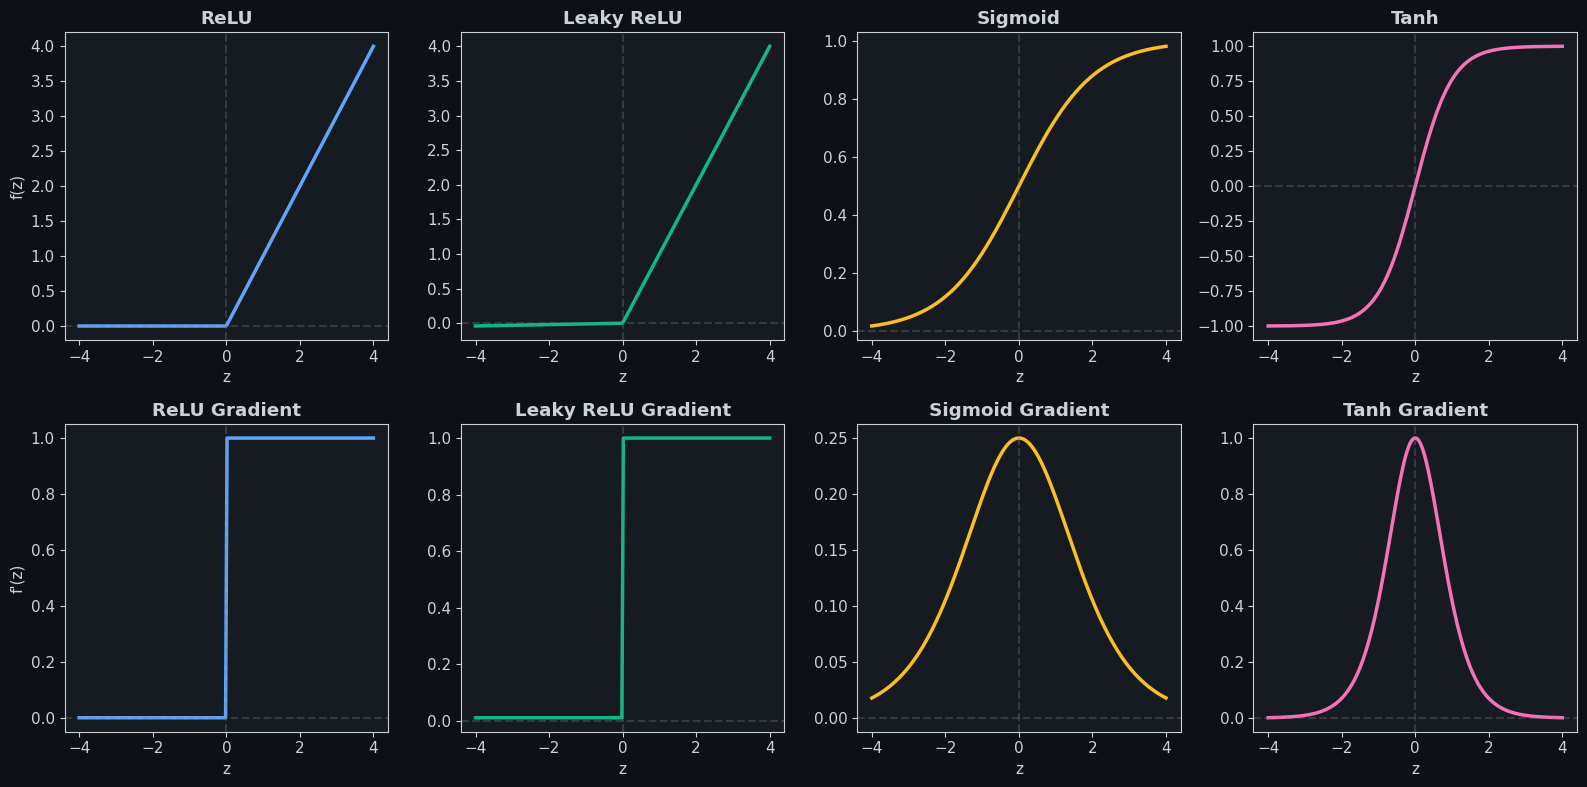

In [13]:
# Implement and visualize all activation gradients

def relu(z):
    return np.maximum(0, z)

def relu_grad(z):
    return (z > 0).astype(float)

def leaky_relu(z, alpha=0.01):
    return np.where(z > 0, z, alpha * z)

def leaky_relu_grad(z, alpha=0.01):
    return np.where(z > 0, 1, alpha)

def tanh(z):
    return np.tanh(z)

def tanh_grad(z):
    return 1 - np.tanh(z)**2

# Visualize
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.patch.set_facecolor('#0d1117')
z = np.linspace(-4, 4, 200)

activations = [
    ('ReLU', relu, relu_grad, '#60A5FA'),
    ('Leaky ReLU', leaky_relu, leaky_relu_grad, '#10B981'),
    ('Sigmoid', sigmoid, sigmoid_derivative, '#FBBF24'),
    ('Tanh', tanh, tanh_grad, '#F472B6'),
]

for i, (name, func, grad_func, color) in enumerate(activations):
    # Function
    axes[0, i].plot(z, func(z), color=color, linewidth=2.5)
    axes[0, i].axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    axes[0, i].axvline(x=0, color='gray', linestyle='--', alpha=0.3)
    axes[0, i].set_title(f'{name}', fontweight='bold')
    axes[0, i].set_xlabel('z')
    if i == 0:
        axes[0, i].set_ylabel('f(z)')

    # Gradient
    axes[1, i].plot(z, grad_func(z), color=color, linewidth=2.5)
    axes[1, i].axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    axes[1, i].axvline(x=0, color='gray', linestyle='--', alpha=0.3)
    axes[1, i].set_title(f"{name} Gradient", fontweight='bold')
    axes[1, i].set_xlabel('z')
    if i == 0:
        axes[1, i].set_ylabel("f'(z)")

plt.tight_layout()
plt.show()

---
# Part 6: Vanishing and Exploding Gradients

## 6.1 The Problem

In deep networks, gradients can become very small (vanishing) or very large (exploding).

**Why?** Because of the chain rule multiplication:

$$\frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial h_n} \cdot \frac{\partial h_n}{\partial h_{n-1}} \cdots \frac{\partial h_2}{\partial h_1} \cdot \frac{\partial h_1}{\partial W_1}$$

If each gradient is < 1, the product shrinks exponentially.
If each gradient is > 1, the product grows exponentially.

In [14]:
# Demonstrate vanishing gradient mathematically
print("="*60)
print("WHY GRADIENTS VANISH WITH SIGMOID")
print("="*60)

print("\nSigmoid derivative: sigma'(z) = sigma(z) * (1 - sigma(z))")
print("Maximum value: 0.25 (at z=0)")

print("\nIn a 10-layer network with sigmoid:")
print("-" * 40)

for n_layers in [5, 10, 20, 50]:
    gradient_factor = 0.25 ** n_layers
    print(f"  {n_layers} layers: gradient shrinks by {gradient_factor:.2e}")

print("\nThis is why deep networks with sigmoid are hard to train!")
print("Solution: Use ReLU (gradient = 1 for positive inputs)")

WHY GRADIENTS VANISH WITH SIGMOID

Sigmoid derivative: sigma'(z) = sigma(z) * (1 - sigma(z))
Maximum value: 0.25 (at z=0)

In a 10-layer network with sigmoid:
----------------------------------------
  5 layers: gradient shrinks by 9.77e-04
  10 layers: gradient shrinks by 9.54e-07
  20 layers: gradient shrinks by 9.09e-13
  50 layers: gradient shrinks by 7.89e-31

This is why deep networks with sigmoid are hard to train!
Solution: Use ReLU (gradient = 1 for positive inputs)


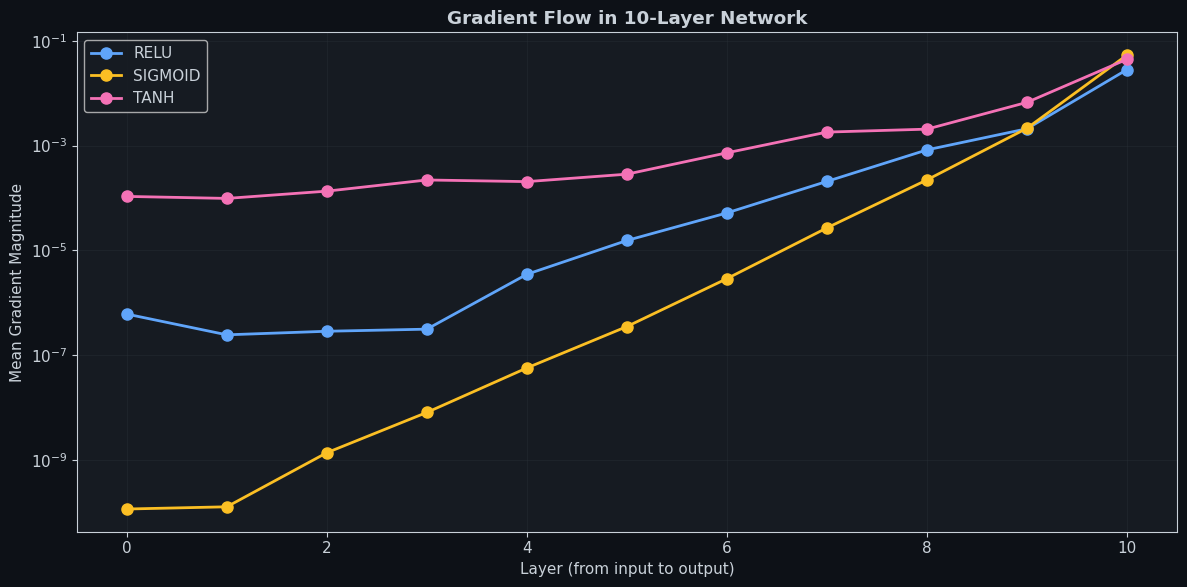


Observation:
  - ReLU: Gradients stay relatively stable
  - Sigmoid/Tanh: Gradients shrink in earlier layers


In [15]:
# Visualize gradient flow in deep networks

def create_deep_network(n_layers, activation='relu'):
    layers = []
    for i in range(n_layers):
        layers.append(nn.Linear(10, 10))
        if activation == 'relu':
            layers.append(nn.ReLU())
        elif activation == 'sigmoid':
            layers.append(nn.Sigmoid())
        elif activation == 'tanh':
            layers.append(nn.Tanh())
    layers.append(nn.Linear(10, 1))
    return nn.Sequential(*layers)

def get_gradient_magnitudes(model):
    """Get gradient magnitudes for each layer."""
    magnitudes = []
    for name, param in model.named_parameters():
        if 'weight' in name and param.grad is not None:
            magnitudes.append(param.grad.abs().mean().item())
    return magnitudes

# Compare activations
n_layers = 10
torch.manual_seed(42)

fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('#0d1117')

activations = ['relu', 'sigmoid', 'tanh']
colors = ['#60A5FA', '#FBBF24', '#F472B6']

for act, color in zip(activations, colors):
    torch.manual_seed(42)
    model = create_deep_network(n_layers, act)

    # Forward and backward
    x = torch.randn(32, 10)
    y = torch.randn(32, 1)
    output = model(x)
    loss = nn.MSELoss()(output, y)
    loss.backward()

    # Get gradient magnitudes
    mags = get_gradient_magnitudes(model)
    ax.plot(range(len(mags)), mags, 'o-', color=color, linewidth=2,
            markersize=8, label=act.upper())

ax.set_xlabel('Layer (from input to output)')
ax.set_ylabel('Mean Gradient Magnitude')
ax.set_title(f'Gradient Flow in {n_layers}-Layer Network', fontweight='bold')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservation:")
print("  - ReLU: Gradients stay relatively stable")
print("  - Sigmoid/Tanh: Gradients shrink in earlier layers")

---
# Part 7: PyTorch Autograd Deep Dive

## 7.1 How PyTorch Tracks Operations

In [16]:
# PyTorch automatically builds computational graph
x = torch.tensor(2.0, requires_grad=True)
w = torch.tensor(3.0, requires_grad=True)
b = torch.tensor(1.0, requires_grad=True)

# Forward pass (graph is built automatically)
h = w * x
z = h + b
L = z ** 2

print("Forward pass:")
print(f"  h = w * x = {w.item()} * {x.item()} = {h.item()}")
print(f"  z = h + b = {h.item()} + {b.item()} = {z.item()}")
print(f"  L = z^2 = {z.item()}^2 = {L.item()}")

print("\nComputational Graph Structure:")
print(f"  L.grad_fn = {L.grad_fn}")
print(f"  z.grad_fn = {z.grad_fn}")
print(f"  h.grad_fn = {h.grad_fn}")

Forward pass:
  h = w * x = 3.0 * 2.0 = 6.0
  z = h + b = 6.0 + 1.0 = 7.0
  L = z^2 = 7.0^2 = 49.0

Computational Graph Structure:
  L.grad_fn = <PowBackward0 object at 0x7d5b648af340>
  z.grad_fn = <AddBackward0 object at 0x7d5b648af340>
  h.grad_fn = <MulBackward0 object at 0x7d5b648af340>


In [17]:
# Backward pass
L.backward()

print("After L.backward():")
print(f"  x.grad = {x.grad.item()}  (dL/dx)")
print(f"  w.grad = {w.grad.item()}  (dL/dw)")
print(f"  b.grad = {b.grad.item()}  (dL/db)")

print("\nManual calculation:")
print(f"  L = (wx + b)^2 = ({w.item()}*{x.item()} + {b.item()})^2 = {L.item()}")
print(f"  dL/dx = 2(wx+b)*w = 2*{z.item()}*{w.item()} = {2*z.item()*w.item()}")
print(f"  dL/dw = 2(wx+b)*x = 2*{z.item()}*{x.item()} = {2*z.item()*x.item()}")
print(f"  dL/db = 2(wx+b)*1 = 2*{z.item()} = {2*z.item()}")

After L.backward():
  x.grad = 42.0  (dL/dx)
  w.grad = 28.0  (dL/dw)
  b.grad = 14.0  (dL/db)

Manual calculation:
  L = (wx + b)^2 = (3.0*2.0 + 1.0)^2 = 49.0
  dL/dx = 2(wx+b)*w = 2*7.0*3.0 = 42.0
  dL/dw = 2(wx+b)*x = 2*7.0*2.0 = 28.0
  dL/db = 2(wx+b)*1 = 2*7.0 = 14.0


## 7.2 Gradient Accumulation

**Important**: PyTorch ACCUMULATES gradients by default!

In [18]:
# Important: Gradients ACCUMULATE by default!
x = torch.tensor(2.0, requires_grad=True)

# First backward
y1 = x ** 2
y1.backward()
print(f"After first backward: x.grad = {x.grad.item()}")

# Second backward (WITHOUT zeroing)
y2 = x ** 2
y2.backward()
print(f"After second backward: x.grad = {x.grad.item()} (ACCUMULATED!)")

print("\nProblem: Gradient is 8 instead of 4!")

After first backward: x.grad = 4.0
After second backward: x.grad = 8.0 (ACCUMULATED!)

Problem: Gradient is 8 instead of 4!


In [19]:
# Correct way: zero gradients before each backward
x = torch.tensor(2.0, requires_grad=True)

# First backward
y1 = x ** 2
y1.backward()
print(f"After first backward: x.grad = {x.grad.item()}")

# Zero gradient
x.grad.zero_()
print("After x.grad.zero_(): x.grad = 0")

# Second backward
y2 = x ** 2
y2.backward()
print(f"After second backward: x.grad = {x.grad.item()} (CORRECT!)")

After first backward: x.grad = 4.0
After x.grad.zero_(): x.grad = 0
After second backward: x.grad = 4.0 (CORRECT!)


---
# Part 8: Summary

## Backpropagation in a Nutshell

1. **Forward Pass**: Compute output and loss, save intermediate values
2. **Backward Pass**: Compute gradients using chain rule, from output to input
3. **Update**: Adjust parameters in opposite direction of gradients

## Key Concepts

| Concept | Description |
|---------|-------------|
| **Chain Rule** | Multiply gradients along the path |
| **Computational Graph** | DAG of operations from input to loss |
| **Local Gradient** | Derivative of one operation |
| **Upstream Gradient** | Gradient from layers above |
| **Vanishing Gradient** | Gradients shrink exponentially in deep networks |
| **Gradient Accumulation** | PyTorch adds gradients; must zero before each backward |

## PyTorch Makes It Easy

```python
# You don't need to implement backprop manually!
loss = criterion(model(x), y)  # Forward
optimizer.zero_grad()           # Zero gradients
loss.backward()                 # Backward (automatic!)
optimizer.step()                # Update parameters
```

But understanding HOW it works helps you:
- Debug training issues
- Design better architectures
- Understand why certain techniques work (batch norm, skip connections, etc.)

---
# Exercises

Each exercise requires BOTH manual calculation AND Python verification.

---

## Exercise 1: Simple Chain Rule

**Problem**: Compute $\frac{dL}{dx}$ for $L = \sin(x^2)$ at $x = 1$.

**Steps**:
1. Let $u = x^2$, so $L = \sin(u)$
2. Apply chain rule: $\frac{dL}{dx} = \frac{dL}{du} \cdot \frac{du}{dx}$

In [20]:
# Exercise 1: L = sin(x^2) at x = 1

# === YOUR MANUAL CALCULATION ===
x = 1.0

# Forward pass
u = x ** 2                    # u = 1
L = np.sin(u)                 # L = sin(1) = 0.8415

# Backward pass
dL_du = np.cos(u)             # d(sin(u))/du = cos(u) = cos(1)
du_dx = 2 * x                 # d(x^2)/dx = 2x = 2
dL_dx_manual = dL_du * du_dx  # Chain rule

print("MANUAL CALCULATION")
print("="*50)
print(f"At x = {x}:")
print(f"  u = x^2 = {u}")
print(f"  L = sin(u) = {L:.4f}")
print(f"\nGradients:")
print(f"  dL/du = cos(u) = cos({u}) = {dL_du:.4f}")
print(f"  du/dx = 2x = {du_dx}")
print(f"  dL/dx = dL/du * du/dx = {dL_du:.4f} * {du_dx} = {dL_dx_manual:.4f}")

# === PYTORCH VERIFICATION ===
x_t = torch.tensor(1.0, requires_grad=True)
L_t = torch.sin(x_t ** 2)
L_t.backward()

print(f"\nPYTORCH VERIFICATION")
print("="*50)
print(f"dL/dx = {x_t.grad.item():.4f}")
print(f"Match: {np.isclose(dL_dx_manual, x_t.grad.item())}")

MANUAL CALCULATION
At x = 1.0:
  u = x^2 = 1.0
  L = sin(u) = 0.8415

Gradients:
  dL/du = cos(u) = cos(1.0) = 0.5403
  du/dx = 2x = 2.0
  dL/dx = dL/du * du/dx = 0.5403 * 2.0 = 1.0806

PYTORCH VERIFICATION
dL/dx = 1.0806
Match: True


## Exercise 2: Multi-Variable Gradients

**Problem**: For $L = (x + y) \cdot (x - y)$ at $x=3$, $y=2$:
1. Compute $\frac{\partial L}{\partial x}$
2. Compute $\frac{\partial L}{\partial y}$

**Hint**: First expand $L = x^2 - y^2$, OR use chain rule with intermediate variables.

In [21]:
# Exercise 2: L = (x + y) * (x - y) at x=3, y=2

# === YOUR SOLUTION ===
x, y = 3.0, 2.0

# Method 1: Expand first
# L = x^2 - y^2
# dL/dx = 2x = 6
# dL/dy = -2y = -4

# Method 2: Use product rule
# Let a = x + y, b = x - y, L = a * b
# dL/da = b, dL/db = a
# da/dx = 1, da/dy = 1
# db/dx = 1, db/dy = -1
# dL/dx = dL/da * da/dx + dL/db * db/dx = b * 1 + a * 1 = (x-y) + (x+y) = 2x
# dL/dy = dL/da * da/dy + dL/db * db/dy = b * 1 + a * (-1) = (x-y) - (x+y) = -2y

# Forward
a = x + y  # 5
b = x - y  # 1
L = a * b  # 5

# Backward
dL_da = b  # 1
dL_db = a  # 5
dL_dx = dL_da * 1 + dL_db * 1    # 1 + 5 = 6
dL_dy = dL_da * 1 + dL_db * (-1)  # 1 - 5 = -4

print("MANUAL CALCULATION")
print("="*50)
print(f"At x={x}, y={y}:")
print(f"  a = x + y = {a}")
print(f"  b = x - y = {b}")
print(f"  L = a * b = {L}")
print(f"\nGradients:")
print(f"  dL/dx = {dL_dx}")
print(f"  dL/dy = {dL_dy}")

# === PYTORCH VERIFICATION ===
x_t = torch.tensor(3.0, requires_grad=True)
y_t = torch.tensor(2.0, requires_grad=True)
L_t = (x_t + y_t) * (x_t - y_t)
L_t.backward()

print(f"\nPYTORCH VERIFICATION")
print("="*50)
print(f"dL/dx = {x_t.grad.item()} (match: {x_t.grad.item() == dL_dx})")
print(f"dL/dy = {y_t.grad.item()} (match: {y_t.grad.item() == dL_dy})")

MANUAL CALCULATION
At x=3.0, y=2.0:
  a = x + y = 5.0
  b = x - y = 1.0
  L = a * b = 5.0

Gradients:
  dL/dx = 6.0
  dL/dy = -4.0

PYTORCH VERIFICATION
dL/dx = 6.0 (match: True)
dL/dy = -4.0 (match: True)


## Exercise 3: Neuron with Tanh Activation

**Problem**: For a single neuron $a = \tanh(wx + b)$ with MSE loss $L = (a - y)^2$:

At $w=0.5$, $x=1.0$, $b=0.2$, $y=0.8$:
1. Compute forward pass values
2. Compute $\frac{\partial L}{\partial w}$ and $\frac{\partial L}{\partial b}$

**Recall**: $\frac{d}{dz}\tanh(z) = 1 - \tanh^2(z)$

In [22]:
# Exercise 3: Neuron with tanh activation

# === YOUR SOLUTION ===
w, x, b, y = 0.5, 1.0, 0.2, 0.8

# Forward pass
z = w * x + b              # z = 0.7
a = np.tanh(z)             # a = tanh(0.7)
L = (a - y) ** 2           # L = (a - 0.8)^2

print("FORWARD PASS")
print("="*50)
print(f"z = w*x + b = {w}*{x} + {b} = {z}")
print(f"a = tanh(z) = tanh({z}) = {a:.4f}")
print(f"L = (a - y)^2 = ({a:.4f} - {y})^2 = {L:.6f}")

# Backward pass
dL_da = 2 * (a - y)            # dL/da = 2(a - y)
da_dz = 1 - np.tanh(z) ** 2    # da/dz = 1 - tanh^2(z)
dL_dz = dL_da * da_dz          # Chain rule

dL_dw = dL_dz * x              # dz/dw = x
dL_db = dL_dz * 1              # dz/db = 1

print("\nBACKWARD PASS")
print("="*50)
print(f"dL/da = 2(a - y) = {dL_da:.4f}")
print(f"da/dz = 1 - tanh^2(z) = {da_dz:.4f}")
print(f"dL/dz = dL/da * da/dz = {dL_dz:.4f}")
print(f"\nFinal gradients:")
print(f"dL/dw = dL/dz * x = {dL_dw:.4f}")
print(f"dL/db = dL/dz = {dL_db:.4f}")

# === PYTORCH VERIFICATION ===
w_t = torch.tensor(w, requires_grad=True)
b_t = torch.tensor(b, requires_grad=True)
x_t = torch.tensor(x)
y_t = torch.tensor(y)

a_t = torch.tanh(w_t * x_t + b_t)
L_t = (a_t - y_t) ** 2
L_t.backward()

print(f"\nPYTORCH VERIFICATION")
print("="*50)
print(f"dL/dw: manual={dL_dw:.4f}, pytorch={w_t.grad.item():.4f}, match={np.isclose(dL_dw, w_t.grad.item())}")
print(f"dL/db: manual={dL_db:.4f}, pytorch={b_t.grad.item():.4f}, match={np.isclose(dL_db, b_t.grad.item())}")

FORWARD PASS
z = w*x + b = 0.5*1.0 + 0.2 = 0.7
a = tanh(z) = tanh(0.7) = 0.6044
L = (a - y)^2 = (0.6044 - 0.8)^2 = 0.038272

BACKWARD PASS
dL/da = 2(a - y) = -0.3913
da/dz = 1 - tanh^2(z) = 0.6347
dL/dz = dL/da * da/dz = -0.2484

Final gradients:
dL/dw = dL/dz * x = -0.2484
dL/db = dL/dz = -0.2484

PYTORCH VERIFICATION
dL/dw: manual=-0.2484, pytorch=-0.2484, match=True
dL/db: manual=-0.2484, pytorch=-0.2484, match=True


## Exercise 4: Matrix Gradient

**Problem**: For a linear layer $Z = XW + b$ where:
- $X$ is shape $(2, 3)$
- $W$ is shape $(3, 2)$
- $b$ is shape $(1, 2)$
- $Z$ is shape $(2, 2)$
- Loss $L = \sum_{ij} Z_{ij}^2$

Given random $X$, $W$, $b$, compute $\frac{\partial L}{\partial W}$ manually and verify.

In [23]:
# Exercise 4: Matrix gradient

# === YOUR SOLUTION ===
np.random.seed(42)
X = np.array([[1.0, 2.0, 3.0],
              [4.0, 5.0, 6.0]])  # (2, 3)

W = np.array([[0.1, 0.2],
              [0.3, 0.4],
              [0.5, 0.6]])      # (3, 2)

b = np.array([[0.1, 0.2]])     # (1, 2)

# Forward pass
Z = X @ W + b  # (2, 2)
L = np.sum(Z ** 2)

print("FORWARD PASS")
print("="*50)
print(f"X shape: {X.shape}")
print(f"W shape: {W.shape}")
print(f"Z = X @ W + b:")
print(Z)
print(f"\nL = sum(Z^2) = {L:.4f}")

# Backward pass
# L = sum(Z^2) => dL/dZ = 2*Z
dL_dZ = 2 * Z  # (2, 2)

# Z = X @ W + b
# dL/dW = X^T @ dL/dZ
dL_dW = X.T @ dL_dZ  # (3, 2)

# dL/db = sum over batch dimension
dL_db = np.sum(dL_dZ, axis=0, keepdims=True)  # (1, 2)

print("\nBACKWARD PASS")
print("="*50)
print(f"dL/dZ = 2*Z:")
print(dL_dZ)
print(f"\ndL/dW = X^T @ dL/dZ:")
print(dL_dW)
print(f"\ndL/db = sum(dL/dZ, axis=0):")
print(dL_db)

# === PYTORCH VERIFICATION ===
X_t = torch.tensor(X, dtype=torch.float32)
W_t = torch.tensor(W, dtype=torch.float32, requires_grad=True)
b_t = torch.tensor(b, dtype=torch.float32, requires_grad=True)

Z_t = X_t @ W_t + b_t
L_t = torch.sum(Z_t ** 2)
L_t.backward()

print(f"\nPYTORCH VERIFICATION")
print("="*50)
print(f"dL/dW matches: {np.allclose(dL_dW, W_t.grad.numpy())}")
print(f"dL/db matches: {np.allclose(dL_db, b_t.grad.numpy())}")

FORWARD PASS
X shape: (2, 3)
W shape: (3, 2)
Z = X @ W + b:
[[2.3 3. ]
 [5.  6.6]]

L = sum(Z^2) = 82.8500

BACKWARD PASS
dL/dZ = 2*Z:
[[ 4.6  6. ]
 [10.  13.2]]

dL/dW = X^T @ dL/dZ:
[[44.6 58.8]
 [59.2 78. ]
 [73.8 97.2]]

dL/db = sum(dL/dZ, axis=0):
[[14.6 19.2]]

PYTORCH VERIFICATION
dL/dW matches: True
dL/db matches: True


## Exercise 5: Implement Leaky ReLU Backward

**Problem**: Implement forward and backward pass for Leaky ReLU:

$$f(x) = \begin{cases} x & \text{if } x > 0 \\ \alpha x & \text{otherwise} \end{cases}$$

With $\alpha = 0.01$

In [24]:
# Exercise 5: Leaky ReLU implementation

class LeakyReLU:
    def __init__(self, alpha=0.01):
        self.alpha = alpha
        self.cache = None

    def forward(self, x):
        """Forward pass: f(x) = x if x > 0, else alpha * x"""
        self.cache = x  # Save for backward
        return np.where(x > 0, x, self.alpha * x)

    def backward(self, dL_dy):
        """Backward pass: df/dx = 1 if x > 0, else alpha"""
        x = self.cache
        df_dx = np.where(x > 0, 1, self.alpha)
        return dL_dy * df_dx


# Test
x = np.array([-2.0, -1.0, 0.0, 1.0, 2.0])
leaky_relu = LeakyReLU(alpha=0.01)

# Forward
y = leaky_relu.forward(x)

# Backward with upstream gradient = 1
dL_dy = np.ones_like(y)
dL_dx = leaky_relu.backward(dL_dy)

print("LEAKY RELU TEST")
print("="*50)
print(f"Input x:      {x}")
print(f"Output y:     {y}")
print(f"Gradient:     {dL_dx}")

# Verify with PyTorch
x_t = torch.tensor(x, dtype=torch.float32, requires_grad=True)
y_t = torch.nn.functional.leaky_relu(x_t, negative_slope=0.01)
y_t.backward(torch.ones_like(y_t))

print(f"\nPyTorch grad: {x_t.grad.numpy()}")
print(f"Match: {np.allclose(dL_dx, x_t.grad.numpy())}")

LEAKY RELU TEST
Input x:      [-2. -1.  0.  1.  2.]
Output y:     [-0.02 -0.01  0.    1.    2.  ]
Gradient:     [0.01 0.01 0.01 1.   1.  ]

PyTorch grad: [0.01 0.01 0.01 1.   1.  ]
Match: True


## Exercise 6: Second Derivative (Hessian)

**Problem**: Compute the second derivative of $f(x) = x^4$ at $x = 2$.

**Steps**:
1. First derivative: $f'(x) = 4x^3$
2. Second derivative: $f''(x) = 12x^2$
3. At $x=2$: $f''(2) = 12 \cdot 4 = 48$

In [25]:
# Exercise 6: Second derivative with PyTorch

# === MANUAL CALCULATION ===
x = 2.0

# f(x) = x^4
# f'(x) = 4x^3
# f''(x) = 12x^2

f_x = x ** 4           # 16
f_prime = 4 * x ** 3   # 32
f_double_prime = 12 * x ** 2  # 48

print("MANUAL CALCULATION")
print("="*50)
print(f"f(x) = x^4")
print(f"f'(x) = 4x^3")
print(f"f''(x) = 12x^2")
print(f"\nAt x = {x}:")
print(f"  f(x) = {f_x}")
print(f"  f'(x) = {f_prime}")
print(f"  f''(x) = {f_double_prime}")

# === PYTORCH VERIFICATION ===
x_t = torch.tensor(2.0, requires_grad=True)

# Compute f(x)
f_t = x_t ** 4

# Compute first derivative
grad1 = torch.autograd.grad(f_t, x_t, create_graph=True)[0]
print(f"\nPYTORCH VERIFICATION")
print("="*50)
print(f"First derivative: {grad1.item()}")

# Compute second derivative
grad2 = torch.autograd.grad(grad1, x_t)[0]
print(f"Second derivative: {grad2.item()}")
print(f"\nMatch: {grad2.item() == f_double_prime}")

MANUAL CALCULATION
f(x) = x^4
f'(x) = 4x^3
f''(x) = 12x^2

At x = 2.0:
  f(x) = 16.0
  f'(x) = 32.0
  f''(x) = 48.0

PYTORCH VERIFICATION
First derivative: 32.0
Second derivative: 48.0

Match: True


## Exercise 7: Custom Autograd Function

**Problem**: Implement a custom PyTorch autograd function for $f(x) = x^3$.

This requires implementing both `forward` and `backward` methods.

In [26]:
# Exercise 7: Custom autograd function

class CubeFunction(torch.autograd.Function):
    """Custom function: f(x) = x^3, f'(x) = 3x^2"""

    @staticmethod
    def forward(ctx, x):
        # Save input for backward
        ctx.save_for_backward(x)
        return x ** 3

    @staticmethod
    def backward(ctx, grad_output):
        # Retrieve saved tensor
        x, = ctx.saved_tensors
        # Gradient: d(x^3)/dx = 3x^2
        grad_input = grad_output * 3 * x ** 2
        return grad_input


# Test
cube = CubeFunction.apply

x = torch.tensor(2.0, requires_grad=True)
y = cube(x)
y.backward()

print("CUSTOM AUTOGRAD FUNCTION TEST")
print("="*50)
print(f"x = {x.item()}")
print(f"y = x^3 = {y.item()}")
print(f"dy/dx = 3x^2 = {x.grad.item()}")
print(f"\nExpected gradient: 3 * {x.item()}^2 = {3 * x.item()**2}")
print(f"Match: {x.grad.item() == 3 * x.item()**2}")

# Verify gradient is correct using gradcheck
x_test = torch.tensor(2.0, requires_grad=True, dtype=torch.float64)
test_passed = torch.autograd.gradcheck(cube, x_test)
print(f"\nGradcheck passed: {test_passed}")

CUSTOM AUTOGRAD FUNCTION TEST
x = 2.0
y = x^3 = 8.0
dy/dx = 3x^2 = 12.0

Expected gradient: 3 * 2.0^2 = 12.0
Match: True

Gradcheck passed: True


## Exercise 8: Softmax Backward

**Problem**: Implement the backward pass for softmax.

For softmax $p_i = \frac{e^{z_i}}{\sum_j e^{z_j}}$, the Jacobian is:

$$\frac{\partial p_i}{\partial z_j} = \begin{cases} p_i(1 - p_i) & \text{if } i = j \\ -p_i p_j & \text{if } i \neq j \end{cases}$$

Or in matrix form: $\frac{\partial p}{\partial z} = \text{diag}(p) - p p^T$

In [27]:
# Exercise 8: Softmax backward

def softmax_forward(z):
    """Numerically stable softmax."""
    z_shifted = z - np.max(z)
    exp_z = np.exp(z_shifted)
    return exp_z / np.sum(exp_z)

def softmax_backward(p, dL_dp):
    """
    Backward pass for softmax.

    Jacobian: J[i,j] = p_i * (1_{i=j} - p_j)
    dL/dz = J^T @ dL/dp
    """
    n = len(p)
    # Jacobian matrix
    jacobian = np.diag(p) - np.outer(p, p)
    # dL/dz = J^T @ dL/dp
    dL_dz = jacobian.T @ dL_dp
    return dL_dz

# Test
z = np.array([1.0, 2.0, 3.0])
p = softmax_forward(z)

# Suppose upstream gradient is [1, 0, 0] (only first output matters)
dL_dp = np.array([1.0, 0.0, 0.0])
dL_dz = softmax_backward(p, dL_dp)

print("SOFTMAX BACKWARD TEST")
print("="*50)
print(f"Input z: {z}")
print(f"Softmax output p: {p}")
print(f"\nUpstream gradient dL/dp: {dL_dp}")
print(f"Computed dL/dz: {dL_dz}")

# Verify with PyTorch
z_t = torch.tensor(z, dtype=torch.float64, requires_grad=True)
p_t = torch.softmax(z_t, dim=0)
p_t.backward(torch.tensor(dL_dp, dtype=torch.float64))

print(f"\nPyTorch dL/dz: {z_t.grad.numpy()}")
print(f"Match: {np.allclose(dL_dz, z_t.grad.numpy())}")

SOFTMAX BACKWARD TEST
Input z: [1. 2. 3.]
Softmax output p: [0.09003057 0.24472847 0.66524096]

Upstream gradient dL/dp: [1. 0. 0.]
Computed dL/dz: [ 0.08192507 -0.02203304 -0.05989202]

PyTorch dL/dz: [ 0.08192507 -0.02203304 -0.05989202]
Match: True


## Exercise 9: Gradient Clipping

**Problem**: Implement gradient clipping with max norm = 1.0.

If $||g|| > \text{max\_norm}$, then $g_{\text{clipped}} = g \cdot \frac{\text{max\_norm}}{||g||}$

In [28]:
# Exercise 9: Gradient clipping

def clip_gradient(grad, max_norm=1.0):
    """
    Clip gradient if its norm exceeds max_norm.

    g_clipped = g * (max_norm / ||g||) if ||g|| > max_norm
    """
    grad_norm = np.linalg.norm(grad)
    if grad_norm > max_norm:
        return grad * (max_norm / grad_norm)
    return grad

# Test
grad_small = np.array([0.3, 0.4])  # norm = 0.5
grad_large = np.array([3.0, 4.0])  # norm = 5.0

print("GRADIENT CLIPPING TEST")
print("="*50)

print(f"\nSmall gradient: {grad_small}")
print(f"  Norm: {np.linalg.norm(grad_small):.2f}")
clipped_small = clip_gradient(grad_small, max_norm=1.0)
print(f"  After clipping: {clipped_small}")
print(f"  Clipped norm: {np.linalg.norm(clipped_small):.2f}")

print(f"\nLarge gradient: {grad_large}")
print(f"  Norm: {np.linalg.norm(grad_large):.2f}")
clipped_large = clip_gradient(grad_large, max_norm=1.0)
print(f"  After clipping: {clipped_large}")
print(f"  Clipped norm: {np.linalg.norm(clipped_large):.2f}")

# Verify with PyTorch
grad_t = torch.tensor(grad_large, dtype=torch.float32)
torch.nn.utils.clip_grad_norm_([grad_t], max_norm=1.0)
# Note: PyTorch clips in-place on parameters, so this is slightly different
print(f"\nDirection preserved: {np.allclose(clipped_large / np.linalg.norm(clipped_large), grad_large / np.linalg.norm(grad_large))}")

GRADIENT CLIPPING TEST

Small gradient: [0.3 0.4]
  Norm: 0.50
  After clipping: [0.3 0.4]
  Clipped norm: 0.50

Large gradient: [3. 4.]
  Norm: 5.00
  After clipping: [0.6 0.8]
  Clipped norm: 1.00

Direction preserved: True


## Exercise 10 (Challenge): Batch Normalization Backward

**Problem**: Implement the backward pass for batch normalization.

Forward:
$$\mu = \frac{1}{N}\sum_i x_i$$
$$\sigma^2 = \frac{1}{N}\sum_i (x_i - \mu)^2$$
$$\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}$$
$$y_i = \gamma \hat{x}_i + \beta$$

In [29]:
# Exercise 10: Batch Normalization backward

class BatchNorm1D:
    """Batch Normalization for 1D inputs."""

    def __init__(self, num_features, eps=1e-5):
        self.eps = eps
        self.gamma = np.ones(num_features)
        self.beta = np.zeros(num_features)
        self.cache = {}

    def forward(self, x):
        """Forward pass."""
        N = x.shape[0]

        # Compute mean and variance
        mu = np.mean(x, axis=0)
        var = np.var(x, axis=0)

        # Normalize
        x_centered = x - mu
        std = np.sqrt(var + self.eps)
        x_norm = x_centered / std

        # Scale and shift
        y = self.gamma * x_norm + self.beta

        # Cache for backward
        self.cache = {
            'x': x, 'x_centered': x_centered, 'std': std,
            'x_norm': x_norm, 'mu': mu, 'var': var, 'N': N
        }

        return y

    def backward(self, dL_dy):
        """Backward pass."""
        x_norm = self.cache['x_norm']
        x_centered = self.cache['x_centered']
        std = self.cache['std']
        N = self.cache['N']

        # Gradients for gamma and beta
        dL_dgamma = np.sum(dL_dy * x_norm, axis=0)
        dL_dbeta = np.sum(dL_dy, axis=0)

        # Gradient for x_norm
        dL_dx_norm = dL_dy * self.gamma

        # Gradient for x (this is the complex part)
        # Using the simplified formula:
        # dL/dx = (1/N) * gamma/std * (N * dL/dy - sum(dL/dy) - x_norm * sum(dL/dy * x_norm))
        dL_dx = (1 / N) * (self.gamma / std) * (
            N * dL_dy
            - np.sum(dL_dy, axis=0)
            - x_norm * np.sum(dL_dy * x_norm, axis=0)
        )

        return dL_dx, dL_dgamma, dL_dbeta


# Test
np.random.seed(42)
x = np.random.randn(4, 3)  # 4 samples, 3 features

bn = BatchNorm1D(3)
y = bn.forward(x)

# Upstream gradient
dL_dy = np.random.randn(4, 3)
dL_dx, dL_dgamma, dL_dbeta = bn.backward(dL_dy)

print("BATCH NORMALIZATION BACKWARD TEST")
print("="*50)
print(f"Input shape: {x.shape}")
print(f"Output shape: {y.shape}")
print(f"\nGradient shapes:")
print(f"  dL/dx: {dL_dx.shape}")
print(f"  dL/dgamma: {dL_dgamma.shape}")
print(f"  dL/dbeta: {dL_dbeta.shape}")

# Verify with PyTorch
x_t = torch.tensor(x, dtype=torch.float64, requires_grad=True)
bn_t = nn.BatchNorm1d(3, eps=1e-5, affine=True, dtype=torch.float64)
bn_t.weight.data.fill_(1.0)  # gamma
bn_t.bias.data.fill_(0.0)    # beta

y_t = bn_t(x_t)
y_t.backward(torch.tensor(dL_dy, dtype=torch.float64))

print(f"\nPYTORCH VERIFICATION")
print("="*50)
print(f"dL/dx matches: {np.allclose(dL_dx, x_t.grad.numpy(), atol=1e-5)}")
print(f"dL/dgamma matches: {np.allclose(dL_dgamma, bn_t.weight.grad.numpy(), atol=1e-5)}")
print(f"dL/dbeta matches: {np.allclose(dL_dbeta, bn_t.bias.grad.numpy(), atol=1e-5)}")

BATCH NORMALIZATION BACKWARD TEST
Input shape: (4, 3)
Output shape: (4, 3)

Gradient shapes:
  dL/dx: (4, 3)
  dL/dgamma: (3,)
  dL/dbeta: (3,)

PYTORCH VERIFICATION
dL/dx matches: True
dL/dgamma matches: True
dL/dbeta matches: True


---

**End of Backpropagation Notebook**